In [88]:
%matplotlib inline
import glob
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import misc
import numpy as np
import cv2

In [116]:
images = glob.glob(os.path.join('..','data', 'samples', '*'))

In [169]:
im = cv2.imread(images[0])
imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
ret, thresh = cv2.threshold(imgray, 3, 255, 0)
contours = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)


In [170]:
x, y, w, h = cv2.boundingRect(contours[0])

In [171]:
crop = im[y:y+h,x:x+w]

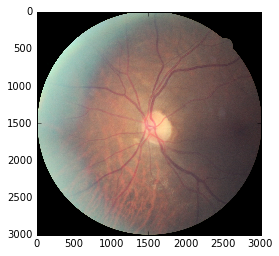

In [172]:
plt.imshow(crop)

In [311]:
def crop(im, threshold=30):
    """
    im = image as np array
    threshold = min pixel value for binary-otsu thresholding
    crops eyes out of each image (removes the black background)
    """
    im = cv2.imread(im)
    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, threshold, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv2.boundingRect(contours[0])
    return im[y:y+h,x:x+w]

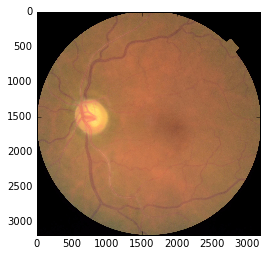

In [317]:
plt.imshow(cv2.cvtColor(crop(images[4]), cv2.COLOR_RGB2BGR))

In [338]:
cropped = crop(images[9])

In [339]:
resized = cv2.resize(cropped, (512, 512))

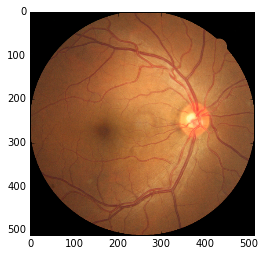

In [345]:
resized = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
plt.imshow(resized)

In [341]:
resized.shape

(512L, 512L, 3L)

In [ ]:
class PreProcessor: